In [1]:
import os
import glob
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from open_flamingo.eval.eval_model import BaseEvalModel
from open_flamingo.src.factory import create_model_and_transforms
from open_flamingo.eval.utils import unwrap_model, get_autocast, get_cast_dtype

/home/chengzhang/anaconda3/envs/minigpt4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model, image_processor, tokenizer = create_model_and_transforms(
    "ViT-L-14",
    "openai",
    "/home/chengzhang/models/mpt/mpt-7b",
    "/home/chengzhang/models/mpt/mpt-7b",
    cross_attn_every_n_layers=1,
)
checkpoint = torch.load("/home/chengzhang/models/openflamingo/OpenFlamingo-9B-vitl-mpt7b/checkpoint.pt")

if "model_state_dict" in checkpoint:
    checkpoint = checkpoint["model_state_dict"]
    checkpoint = {k.replace("module.", ""): v for k, v in checkpoint.items()}
model.load_state_dict(checkpoint, strict=False)
model.cuda()
model = model.to(torch.float16)
model.eval()
tokenizer.padding_side = "left"
tokenizer.add_eos_token = False

Using pad_token, but it is not set yet.


[2023-09-08 04:11:31,193] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Instantiating an MPTForCausalLM model from /home/chengzhang/.cache/huggingface/modules/transformers_modules/mpt-7b/modeling_mpt.py
You are using config.init_device='cpu', but you can also use config.init_device="meta" with Composer + FSDP for fast initialization.


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.72s/it]
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 50280. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Flamingo model initialized with 4732229696 trainable parameters


In [3]:
model.lang_encoder

MPTForCausalLM(
  (transformer): MPTModel(
    (wte): Embedding(50280, 4096)
    (emb_drop): Dropout(p=0, inplace=False)
    (blocks): ModuleList(
      (0-31): 32 x FlamingoLayer(
        (gated_cross_attn_layer): GatedCrossAttentionBlock(
          (attn): MaskedCrossAttention(
            (norm): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
            (to_q): Linear(in_features=4096, out_features=512, bias=False)
            (to_kv): Linear(in_features=1024, out_features=1024, bias=False)
            (to_out): Linear(in_features=512, out_features=4096, bias=False)
          )
          (ff): Sequential(
            (0): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=4096, out_features=16384, bias=False)
            (2): GELU(approximate='none')
            (3): Linear(in_features=16384, out_features=4096, bias=False)
          )
        )
        (decoder_layer): MPTBlock(
          (norm_1): LPLayerNorm((4096,), eps=1e-05, elem

In [5]:
linear_modules: dict[str, torch.nn.Module] = {}

for i, layer in enumerate(model.lang_encoder.transformer.blocks):
    for x in ['Wqkv', 'out_proj']:
        proj_id = f'mpt/{i}-self-{x}'
        linear_modules[proj_id] = getattr(layer.decoder_layer.attn, f'{x}')
    for x in ['down', 'up']:
        proj_id = f'mpt/{i}-self-{x}-proj'
        linear_modules[proj_id] = getattr(layer.decoder_layer.ffn, f'{x}_proj')
    for x in ['q', 'kv', 'out']:
        proj_id = f'mpt/{i}-cross-{x}-proj'
        linear_modules[proj_id] = getattr(layer.gated_cross_attn_layer.attn, f'to_{x}')
    for j, name in [(1, 'fc1'), (3, 'fc2')]:
        proj_id = f'mpt/{i}-cross-{name}'
        linear_modules[proj_id] = layer.gated_cross_attn_layer.ff[j]

for name, module in linear_modules.items():
    module.unique_name = name

ln_modules: dict[str, torch.nn.Linear] = {}

for i, layer in enumerate(model.lang_encoder.transformer.blocks):
    ln_modules[f'mpt/{i}-self-input-ln'] = layer.decoder_layer.norm_1
    ln_modules[f'mpt/{i}-self-post-attn-ln'] = layer.decoder_layer.norm_2
    ln_modules[f'mpt/{i}-cross-input-ln'] = layer.gated_cross_attn_layer.attn.norm
    ln_modules[f'mpt/{i}-cross-post-attn-ln'] = layer.gated_cross_attn_layer.ff[0]

for name, module in ln_modules.items():
    module.unique_name = name

In [6]:
with open('/home/chengzhang/datasets/OK-VQA/question/OpenEnded_mscoco_val2014_questions.json') as f:
    questions = json.loads(f.read())['questions']

hooks = []

In [7]:
SNAPSHOT_PATH = '/home/chengzhang/Multimodal-Quantization/open_flamingo/snapshot'

In [8]:
def save_activations(hooks):

    for i in range(10):

        q = questions[i]
        question = q['question']
        image_id = q['image_id']
        question_id = q['question_id']
        image = Image.open(f'/home/chengzhang/datasets/OK-VQA/images/val2014/COCO_val2014_{str(image_id).zfill(12)}.jpg')
        vision_x = image_processor(image).unsqueeze(0).unsqueeze(1).unsqueeze(0).half()
        lang_x = tokenizer([question], return_tensors="pt")

        act_folder = f'/home/chengzhang/Multimodal-Quantization/open_flamingo/snapshot/activations-mpt/{question_id}'
        os.makedirs(f'{act_folder}/vit', exist_ok=True)
        os.makedirs(f'{act_folder}/perceiver', exist_ok=True)
        os.makedirs(f'{act_folder}/mpt', exist_ok=True)

        for hook in hooks:
            hook.remove()
        hooks = []

        def hook(m, input, output):
            torch.save(input, f'{act_folder}/{m.unique_name}.pt')

        for name, module in linear_modules.items():
            hooks.append(module.register_forward_hook(hook))

        for name, module in ln_modules.items():
            hooks.append(module.register_forward_hook(hook))

        model(vision_x=vision_x.cuda(), lang_x=lang_x["input_ids"].cuda())

save_activations(hooks)

In [9]:
def plot_activations(ax: plt.Axes, model_name: str, component: str, text_only: str = False):
    snapshot_prefix = 'activations'
    if text_only:
        snapshot_prefix = 'text-' + snapshot_prefix
        title = 'activations (text only)'
    else:
        title = 'activations'
    paths = glob.glob(f'{SNAPSHOT_PATH}/{snapshot_prefix}-mpt/*/{model_name}/*-{component}')
    groups: dict[int, list] = {}
    for path in paths:
        file_name = os.path.split(path)[-1]
        idx = int(file_name.split('-')[0])
        if not idx in groups:
            groups[idx] = []
        groups[idx].append(path)
    layers = []
    for idx in sorted(list(groups.keys())):
        shots = np.array([])
        for path in groups[idx]:
            shot = torch.load(path)[0].detach().abs().max(axis=-1).values.flatten().cpu().numpy()
            shots = np.concatenate([shots, shot])
        layers.append(shots)
    ax.boxplot(layers)
    ax.tick_params(axis='x', rotation=60)
    ax.set_xlabel('layer')
    ax.set_ylabel('max abs value of each token')
    ax.set_title(f'[{model_name}] ' + component.split('.')[0] + f': {title}')

In [10]:
def plot_weights(ax: plt.Axes, layer_num: int, model_name: str, component: str):
    layers = []
    for i in range(layer_num):
        weight = linear_modules[f'{model_name}/{i}-' + component.split('.')[0]].weight.detach().flatten().cpu().numpy()
        layers.append(weight)
    ax.boxplot(layers)
    ax.tick_params(axis='x', rotation=60)
    ax.set_xlabel('layer')
    # ax.set_ylabel('max abs value of each row')
    ax.set_ylabel('abs value')
    ax.set_title(component.split('.')[0] + ': weights')

self-Wqkv.pt


self-out_proj.pt
self-up-proj.pt
self-down-proj.pt


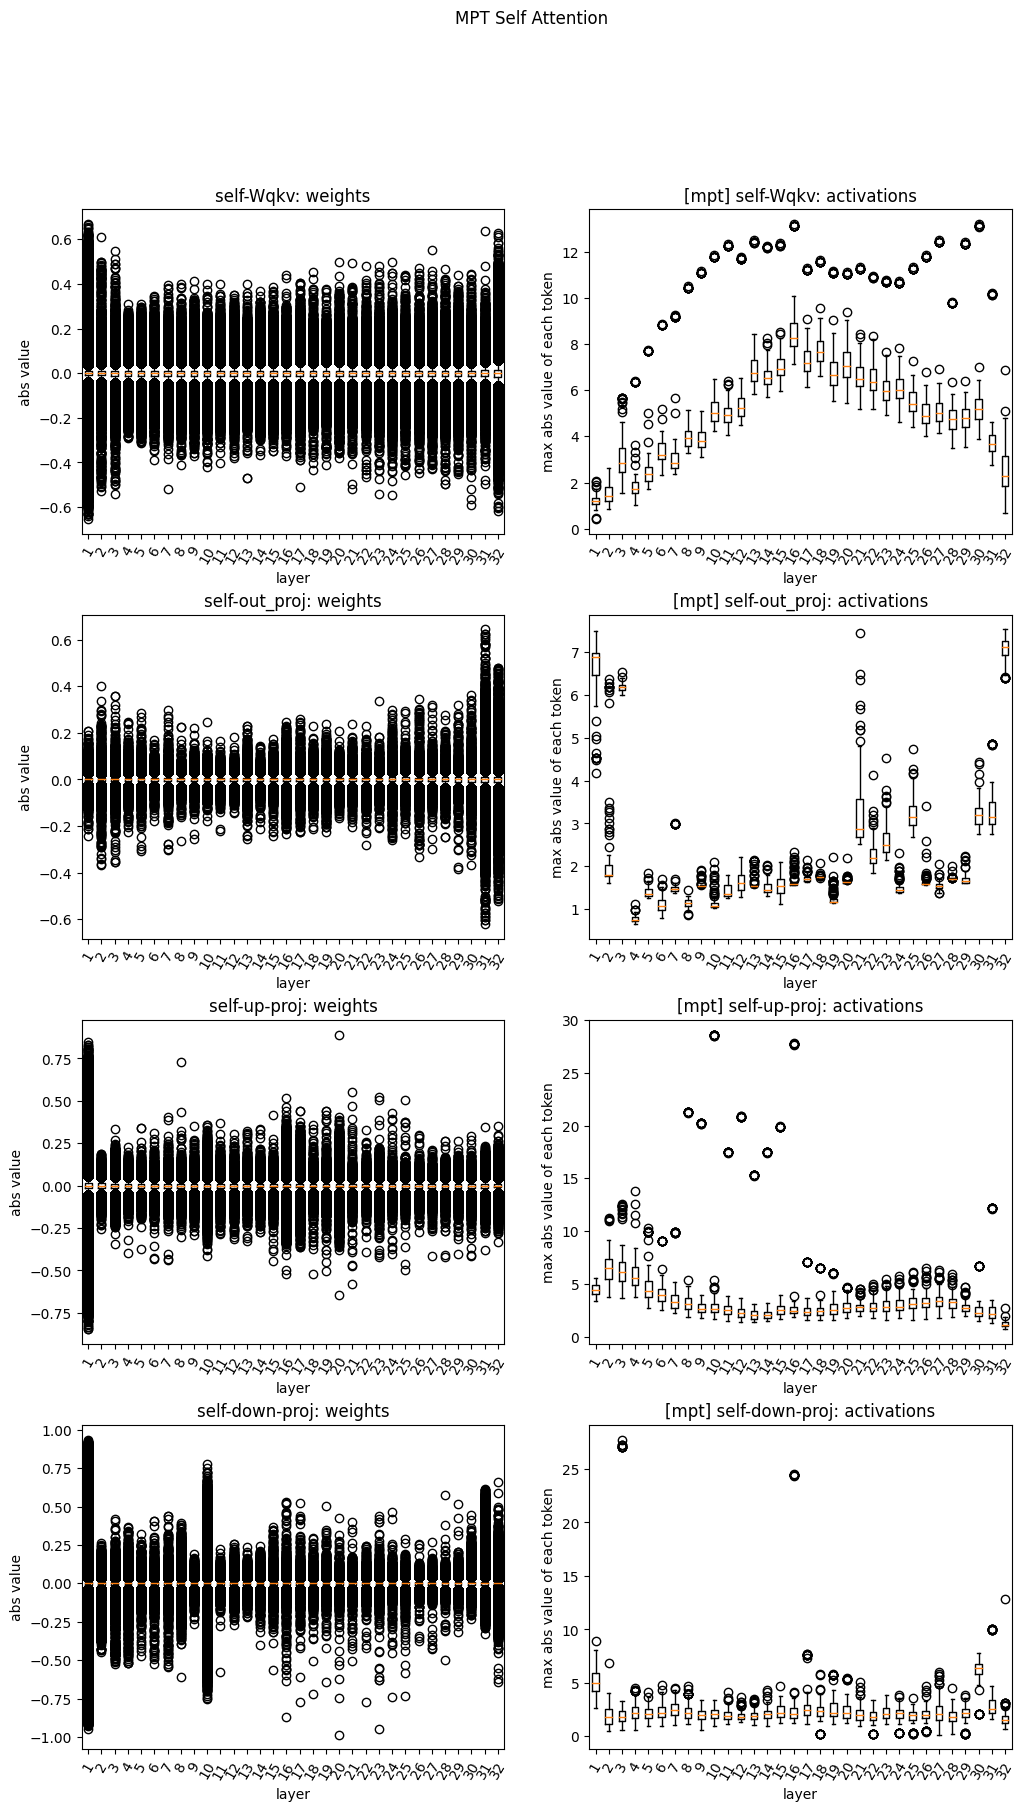

In [11]:
model_name = 'mpt'
fig = plt.figure(figsize=(12, 20))
plt.subplots_adjust(hspace=0.25)
for i, component in enumerate([
    'self-Wqkv.pt',
    'self-out_proj.pt',
    'self-up-proj.pt',
    'self-down-proj.pt',
]):
    print(component)
    ax = plt.subplot2grid((4, 2), (i, 0))
    plot_weights(ax, 32, model_name, component)
    ax = plt.subplot2grid((4, 2), (i, 1))
    plot_activations(ax, model_name, component)
plt.suptitle('MPT Self Attention')
plt.savefig(f'{SNAPSHOT_PATH}/img/mpt-self.png')

cross-q-proj.pt


cross-kv-proj.pt
cross-out-proj.pt
cross-fc1.pt
cross-fc2.pt


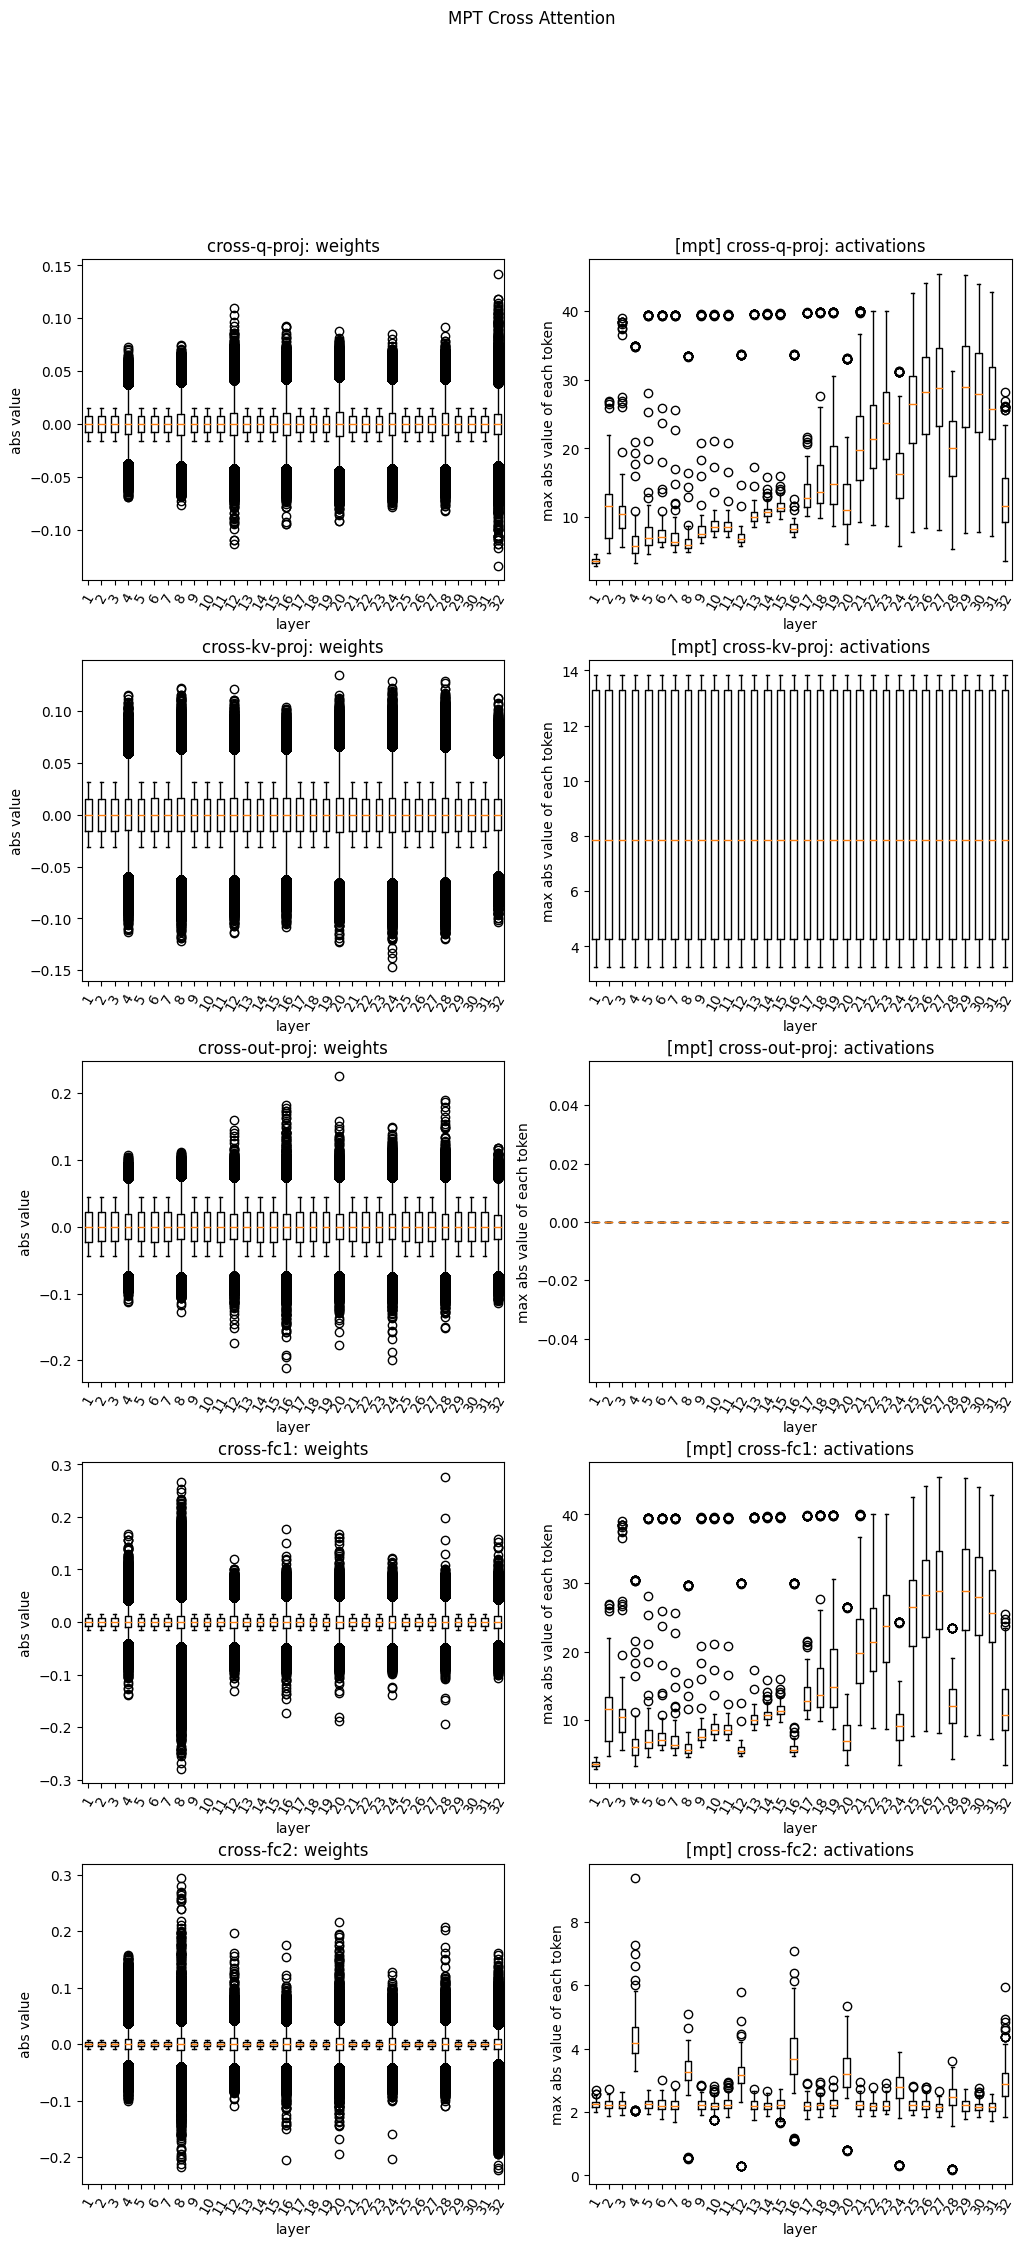

In [13]:
model_name = 'mpt'
fig = plt.figure(figsize=(12, 25))
plt.subplots_adjust(hspace=0.25)
for i, component in enumerate([
    'cross-q-proj.pt',
    'cross-kv-proj.pt',
    'cross-out-proj.pt',
    'cross-fc1.pt',
    'cross-fc2.pt',
]):
    print(component)
    ax = plt.subplot2grid((5, 2), (i, 0))
    plot_weights(ax, 32, model_name, component)
    ax = plt.subplot2grid((5, 2), (i, 1))
    plot_activations(ax, model_name, component)
plt.suptitle('MPT Cross Attention')
plt.savefig(f'{SNAPSHOT_PATH}/img/mpt-cross.png')

self-input-ln.pt
self-post-attn-ln.pt
cross-input-ln.pt
cross-post-attn-ln.pt


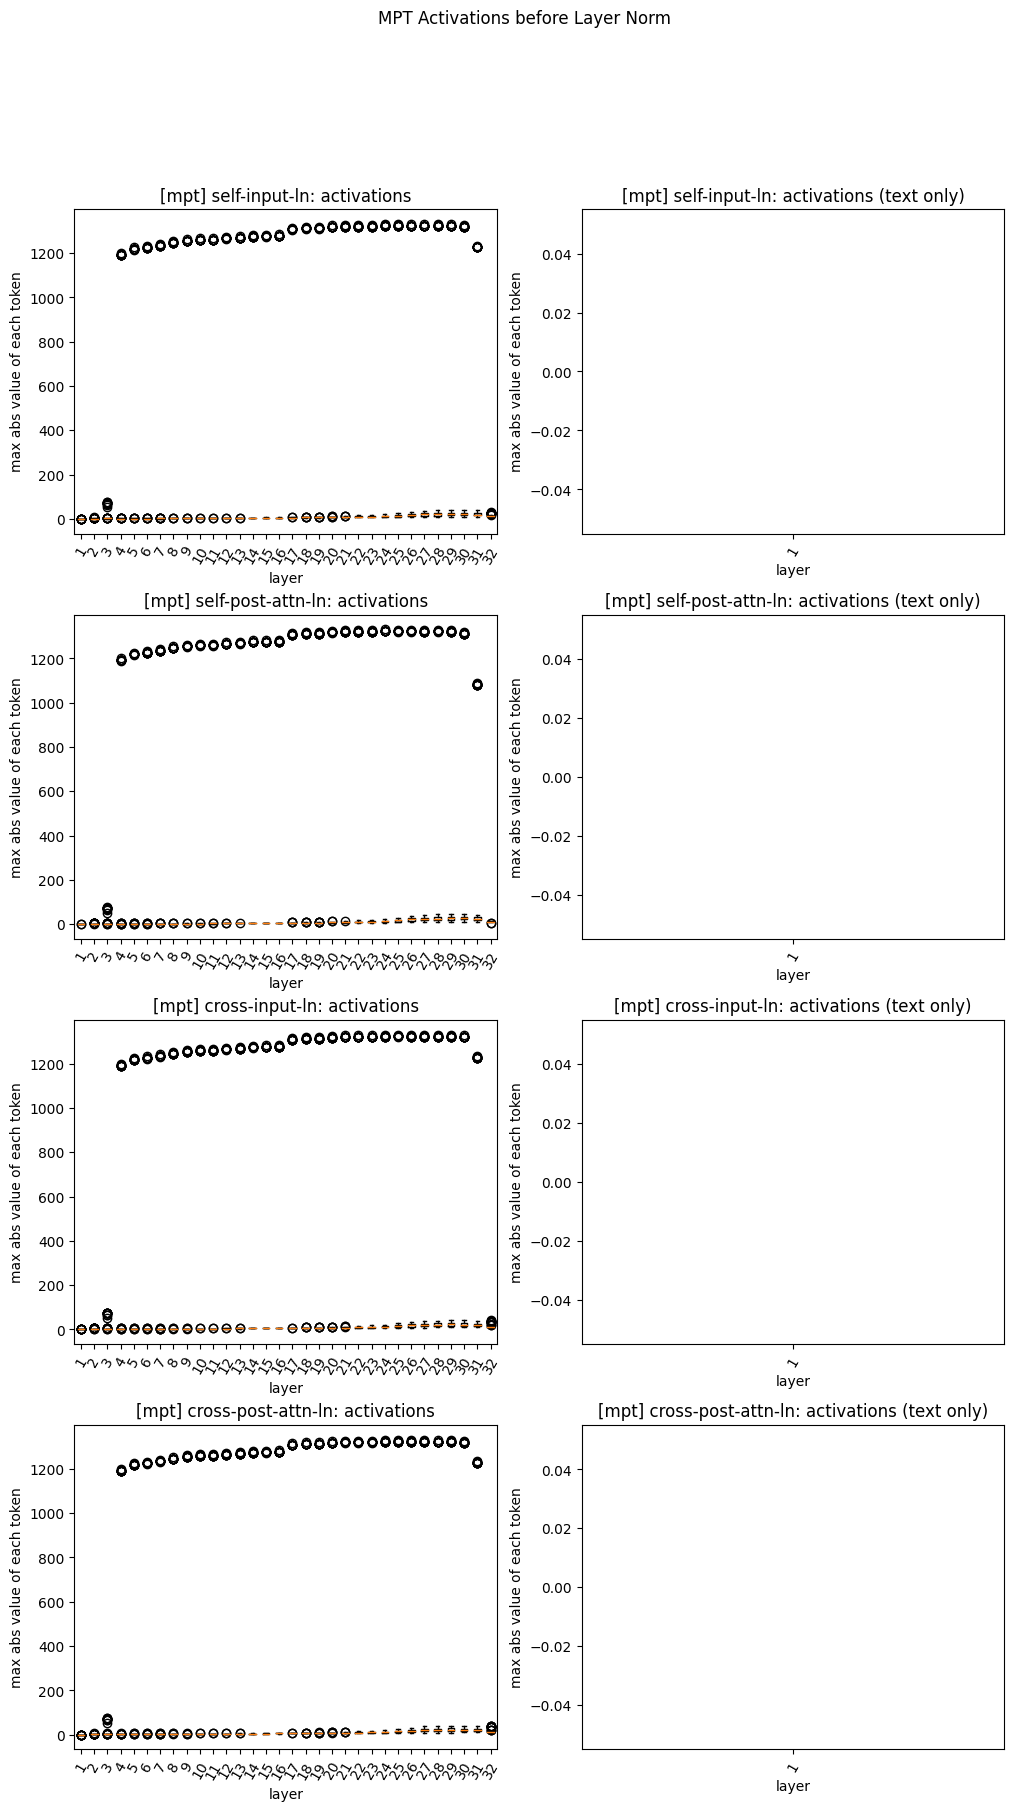

In [14]:
model_name = 'mpt'
fig = plt.figure(figsize=(12, 20))
plt.subplots_adjust(hspace=0.25)
for i, component in enumerate([
    'self-input-ln.pt',
    'self-post-attn-ln.pt',
    'cross-input-ln.pt',
    'cross-post-attn-ln.pt',
]):
    print(component)
    ax = plt.subplot2grid((4, 2), (i, 0))
    plot_activations(ax, model_name, component)
    ax = plt.subplot2grid((4, 2), (i, 1))
    plot_activations(ax, model_name, component, text_only=True)
plt.suptitle('MPT Activations before Layer Norm')
plt.savefig(f'{SNAPSHOT_PATH}/img/mpt-before-ln.png')

In [15]:
def plot_tensor(field: str, model_name: str, component: str):
    tensor = torch.load(f'{SNAPSHOT_PATH}/{field}/{model_name}/{component}')
    tensor = tensor[0].detach().squeeze(0).abs()
    tensor = tensor.cpu().numpy()

    print(tensor.shape)
    plt.clf()
    fig = plt.figure(figsize=(12, 4))
    ax = plt.subplot(121)
    sns.heatmap(tensor, ax=ax)
    ax.set_xlabel('channel')
    ax.set_ylabel('tokens')

    _x, _y = np.arange(tensor.shape[1]), np.arange(tensor.shape[0])
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()
    ax = plt.subplot(122, projection='3d')
    colors = np.tile(tensor.max(axis=0).reshape((1, -1)), (tensor.shape[0], 1)).flatten()
    colors = plt.cm.jet(colors / tensor.max())
    tensor = tensor.flatten()
    ax.bar3d(x, y, 0, 1, 1, tensor, color=colors, shade=False)

    ax.set_xlabel('channel')
    ax.set_ylabel('tokens')
    # ax.set_zlabel('value')

    name = component[:-3]
    layer = name.split('-')[0]
    plt.suptitle(model_name + ' ' + field + f' #{name}')
    os.makedirs(f'{SNAPSHOT_PATH}/img/mpt-layer-{layer}', exist_ok=True)
    plt.savefig(f'{SNAPSHOT_PATH}/img/mpt-layer-{layer}/{name}.png')

(8, 4096)


(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(64, 1024)
(8, 512)


/tmp/ipykernel_3698417/3499165081.py:19: RuntimeWarning: invalid value encountered in divide
  colors = plt.cm.jet(colors / tensor.max())


(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)


/tmp/ipykernel_3698417/3499165081.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12, 4))


(8, 4096)
(64, 1024)
(8, 512)


/tmp/ipykernel_3698417/3499165081.py:19: RuntimeWarning: invalid value encountered in divide
  colors = plt.cm.jet(colors / tensor.max())


(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(64, 1024)
(8, 512)


/tmp/ipykernel_3698417/3499165081.py:19: RuntimeWarning: invalid value encountered in divide
  colors = plt.cm.jet(colors / tensor.max())


(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(64, 1024)
(8, 512)


/tmp/ipykernel_3698417/3499165081.py:19: RuntimeWarning: invalid value encountered in divide
  colors = plt.cm.jet(colors / tensor.max())


(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(64, 1024)
(8, 512)


/tmp/ipykernel_3698417/3499165081.py:19: RuntimeWarning: invalid value encountered in divide
  colors = plt.cm.jet(colors / tensor.max())


(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(64, 1024)
(8, 512)


/tmp/ipykernel_3698417/3499165081.py:19: RuntimeWarning: invalid value encountered in divide
  colors = plt.cm.jet(colors / tensor.max())


(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(64, 1024)
(8, 512)


/tmp/ipykernel_3698417/3499165081.py:19: RuntimeWarning: invalid value encountered in divide
  colors = plt.cm.jet(colors / tensor.max())


(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(64, 1024)
(8, 512)


/tmp/ipykernel_3698417/3499165081.py:19: RuntimeWarning: invalid value encountered in divide
  colors = plt.cm.jet(colors / tensor.max())


(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 4096)
(8, 16384)
(8, 4096)
(8, 4096)
(64, 1024)
(8, 512)


/tmp/ipykernel_3698417/3499165081.py:19: RuntimeWarning: invalid value encountered in divide
  colors = plt.cm.jet(colors / tensor.max())


(8, 4096)
(8, 4096)
(8, 16384)


<Figure size 640x480 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

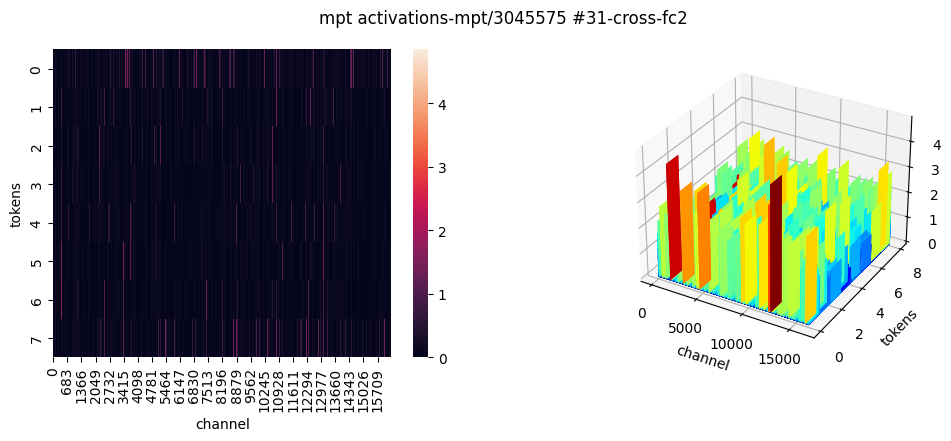

In [20]:
for i in [0, 3, 7, 11, 15, 19, 23, 27, 31]:
    plot_tensor('activations-mpt/3045575', 'mpt', f'{i}-self-input-ln.pt')
    plot_tensor('activations-mpt/3045575', 'mpt', f'{i}-self-Wqkv.pt')
    plot_tensor('activations-mpt/3045575', 'mpt', f'{i}-self-out_proj.pt')
    plot_tensor('activations-mpt/3045575', 'mpt', f'{i}-self-post-attn-ln.pt')
    plot_tensor('activations-mpt/3045575', 'mpt', f'{i}-self-up-proj.pt')
    plot_tensor('activations-mpt/3045575', 'mpt', f'{i}-self-down-proj.pt')
    plot_tensor('activations-mpt/3045575', 'mpt', f'{i}-cross-input-ln.pt')
    plot_tensor('activations-mpt/3045575', 'mpt', f'{i}-cross-q-proj.pt')
    plot_tensor('activations-mpt/3045575', 'mpt', f'{i}-cross-kv-proj.pt')
    plot_tensor('activations-mpt/3045575', 'mpt', f'{i}-cross-out-proj.pt')
    plot_tensor('activations-mpt/3045575', 'mpt', f'{i}-cross-post-attn-ln.pt')
    plot_tensor('activations-mpt/3045575', 'mpt', f'{i}-cross-fc1.pt')
    plot_tensor('activations-mpt/3045575', 'mpt', f'{i}-cross-fc2.pt')